In [ ]:


DEVICE="cpu"
dataset = "multi_news" #xsum,writing,pubmed,english,german
dataset_key="summary" #document
pct_words_masked=0.3
span_length=2
n_samples=150 #200,312
n_perturbation_list="10"
n_perturbation_rounds=1
base_model_name="gpt2"
scoring_model_name=""
mask_filling_model_name="t5-small"
batch_size=5
chunk_size=20
n_similarity_samples=20
int8=False
half=False
base_half=False
do_top_k=False
top_k=40
do_top_p=True
top_p=0.9
output_name="scale"
openai_model=None
openai_key=None
baselines_only=False
skip_baselines=False
buffer_size=1
mask_top_p=0.95
pre_perturb_pct=0.0
pre_perturb_span_length=5
random_fills=False
random_fills_tokens=True
cache_dir="/"
args_dict={'dataset': 'multi_news', 'dataset_key': 'summary', 'pct_words_masked': 0.3, 'span_length': 2,
 'n_samples': 150, 'n_perturbation_list': '10', 'n_perturbation_rounds': 1,
 'base_model_name': 'gpt2', 'scoring_model_name': '', 'mask_filling_model_name': 't5-small',
 'batch_size': 5, 'chunk_size': 20, 'n_similarity_samples': 20, 'int8': False, 'half': False,
 'base_half': False, 'do_top_k': False, 'top_k': 40, 'do_top_p': True, 'top_p': 0.9,
 'output_name': 'scale', 'openai_model': None, 'openai_key': None, 'baselines_only': False,
 'skip_baselines': False, 'buffer_size': 1, 'mask_top_p': 0.95, 'pre_perturb_pct': 0.0,
 'pre_perturb_span_length': 5, 'random_fills': False, 'random_fills_tokens': True,
 'cache_dir': '/'}

In [ ]:
!pip install datasets
!pip install openai


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.8/220.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import datasets
import transformers
import re
import torch
import torch.nn.functional as F
import tqdm
import random
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import argparse
import datetime
import os
import json
import functools

from multiprocessing.pool import ThreadPool
import time
import openai

In [ ]:
import random
import datasets

SEPARATOR = '<<<SEP>>>'


DATASETS = ['writing', 'english', 'german', 'pubmed']


def load_pubmed(cache_dir):
    data = datasets.load_dataset('pubmed_qa', 'pqa_labeled', split='train', cache_dir=cache_dir)

    # combine question and long_answer
    data = [f'Question: {q} Answer:{SEPARATOR}{a}' for q, a in zip(data['question'], data['long_answer'])]

    return data


def process_prompt(prompt):
    return prompt.replace('[ WP ]', '').replace('[ OT ]', '')


def process_spaces(story):
    return story.replace(
        ' ,', ',').replace(
        ' .', '.').replace(
        ' ?', '?').replace(
        ' !', '!').replace(
        ' ;', ';').replace(
        ' \'', '\'').replace(
        ' ’ ', '\'').replace(
        ' :', ':').replace(
        '<newline>', '\n').replace(
        '`` ', '"').replace(
        ' \'\'', '"').replace(
        '\'\'', '"').replace(
        '.. ', '... ').replace(
        ' )', ')').replace(
        '( ', '(').replace(
        ' n\'t', 'n\'t').replace(
        ' i ', ' I ').replace(
        ' i\'', ' I\'').replace(
        '\\\'', '\'').replace(
        '\n ', '\n').strip()


def load_writing(cache_dir=None):
    writing_path = 'data/writingPrompts'

    with open(f'{writing_path}/valid.wp_source', 'r') as f:
        prompts = f.readlines()
    with open(f'{writing_path}/valid.wp_target', 'r') as f:
        stories = f.readlines()

    prompts = [process_prompt(prompt) for prompt in prompts]
    joined = [process_spaces(prompt + " " + story) for prompt, story in zip(prompts, stories)]
    filtered = [story for story in joined if 'nsfw' not in story and 'NSFW' not in story]

    random.seed(0)
    random.shuffle(filtered)

    return filtered


def load_language(language, cache_dir):
    # load either the english or german portion of the wmt16 dataset
    assert language in ['en', 'de']
    d = datasets.load_dataset('wmt16', 'de-en', split='train', cache_dir=cache_dir)
    docs = d['translation']
    desired_language_docs = [d[language] for d in docs]
    lens = [len(d.split()) for d in desired_language_docs]
    sub = [d for d, l in zip(desired_language_docs, lens) if l > 100 and l < 150]
    return sub


def load_german(cache_dir):
    return load_language('de', cache_dir)


def load_english(cache_dir):
    return load_language('en', cache_dir)


def load(name, cache_dir, **kwargs):
    if name in DATASETS:
        load_fn = globals()[f'load_{name}']
        return load_fn(cache_dir=cache_dir, **kwargs)
    else:
        raise ValueError(f'Unknown dataset {name}')

In [ ]:


# 15 colorblind-friendly colors
COLORS = ["#0072B2", "#009E73", "#D55E00", "#CC79A7", "#F0E442",
            "#56B4E9", "#E69F00", "#000000", "#0072B2", "#009E73",
            "#D55E00", "#CC79A7", "#F0E442", "#56B4E9", "#E69F00"]

# define regex to match all <extra_id_*> tokens, where * is an integer
pattern = re.compile(r"<extra_id_\d+>")


def load_base_model():
    print('MOVING BASE MODEL TO GPU...', end='', flush=True)
    start = time.time()
    try:
        mask_model.cpu()
    except NameError:
        pass
    if openai_model is None:
        base_model.to(DEVICE)
    print(f'DONE ({time.time() - start:.2f}s)')


def load_mask_model():
    print('MOVING MASK MODEL TO GPU...', end='', flush=True)
    start = time.time()

    if openai_model is None:
        base_model.cpu()
    if not random_fills:
        mask_model.to(DEVICE)
    print(f'DONE ({time.time() - start:.2f}s)')


def tokenize_and_mask(text, span_length, pct, ceil_pct=False):
    tokens = text.split(' ')
    mask_string = '<<<mask>>>'

    n_spans = pct * len(tokens) / (span_length + buffer_size * 2)
    if ceil_pct:
        n_spans = np.ceil(n_spans)
    n_spans = int(n_spans)

    n_masks = 0
    while n_masks < n_spans:
        start = np.random.randint(0, len(tokens) - span_length)
        end = start + span_length
        search_start = max(0, start - buffer_size)
        search_end = min(len(tokens), end + buffer_size)
        if mask_string not in tokens[search_start:search_end]:
            tokens[start:end] = [mask_string]
            n_masks += 1

    # replace each occurrence of mask_string with <extra_id_NUM>, where NUM increments
    num_filled = 0
    for idx, token in enumerate(tokens):
        if token == mask_string:
            tokens[idx] = f'<extra_id_{num_filled}>'
            num_filled += 1
    assert num_filled == n_masks, f"num_filled {num_filled} != n_masks {n_masks}"
    text = ' '.join(tokens)
    return text


def count_masks(texts):
    return [len([x for x in text.split() if x.startswith("<extra_id_")]) for text in texts]


# replace each masked span with a sample from T5 mask_model
def replace_masks(texts):
    n_expected = count_masks(texts)
    stop_id = mask_tokenizer.encode(f"<extra_id_{max(n_expected)}>")[0]
    tokens = mask_tokenizer(texts, return_tensors="pt", padding=True).to(DEVICE)
    outputs = mask_model.generate(**tokens, max_length=150, do_sample=True, top_p= mask_top_p, num_return_sequences=1, eos_token_id=stop_id)
    return mask_tokenizer.batch_decode(outputs, skip_special_tokens=False)


def extract_fills(texts):
    # remove <pad> from beginning of each text
    texts = [x.replace("<pad>", "").replace("</s>", "").strip() for x in texts]

    # return the text in between each matched mask token
    extracted_fills = [pattern.split(x)[1:-1] for x in texts]

    # remove whitespace around each fill
    extracted_fills = [[y.strip() for y in x] for x in extracted_fills]

    return extracted_fills


def apply_extracted_fills(masked_texts, extracted_fills):
    # split masked text into tokens, only splitting on spaces (not newlines)
    tokens = [x.split(' ') for x in masked_texts]

    n_expected = count_masks(masked_texts)

    # replace each mask token with the corresponding fill
    for idx, (text, fills, n) in enumerate(zip(tokens, extracted_fills, n_expected)):
        if len(fills) < n:
            tokens[idx] = []
        else:
            for fill_idx in range(n):
                text[text.index(f"<extra_id_{fill_idx}>")] = fills[fill_idx]

    # join tokens back into text
    texts = [" ".join(x) for x in tokens]
    return texts


def perturb_texts_(texts, span_length, pct, ceil_pct=False):
    if not random_fills:
        masked_texts = [tokenize_and_mask(x, span_length, pct, ceil_pct) for x in texts]
        raw_fills = replace_masks(masked_texts)
        extracted_fills = extract_fills(raw_fills)
        perturbed_texts = apply_extracted_fills(masked_texts, extracted_fills)

        # Handle the fact that sometimes the model doesn't generate the right number of fills and we have to try again
        attempts = 1
        while '' in perturbed_texts:
            idxs = [idx for idx, x in enumerate(perturbed_texts) if x == '']
            print(f'WARNING: {len(idxs)} texts have no fills. Trying again [attempt {attempts}].')
            masked_texts = [tokenize_and_mask(x, span_length, pct, ceil_pct) for idx, x in enumerate(texts) if idx in idxs]
            raw_fills = replace_masks(masked_texts)
            extracted_fills = extract_fills(raw_fills)
            new_perturbed_texts = apply_extracted_fills(masked_texts, extracted_fills)
            for idx, x in zip(idxs, new_perturbed_texts):
                perturbed_texts[idx] = x
            attempts += 1
    else:
        if random_fills_tokens:
            # tokenize base_tokenizer
            tokens = base_tokenizer(texts, return_tensors="pt", padding=True).to(DEVICE)
            valid_tokens = tokens.input_ids != base_tokenizer.pad_token_id
            replace_pct = pct_words_masked * (span_length / (span_length + 2 * buffer_size))

            # replace replace_pct of input_ids with random tokens
            random_mask = torch.rand(tokens.input_ids.shape, device=DEVICE) < replace_pct
            random_mask &= valid_tokens
            random_tokens = torch.randint(0, base_tokenizer.vocab_size, (random_mask.sum(),), device=DEVICE)
            # while any of the random tokens are special tokens, replace them with random non-special tokens
            while any(base_tokenizer.decode(x) in base_tokenizer.all_special_tokens for x in random_tokens):
                random_tokens = torch.randint(0, base_tokenizer.vocab_size, (random_mask.sum(),), device=DEVICE)
            tokens.input_ids[random_mask] = random_tokens
            perturbed_texts = base_tokenizer.batch_decode(tokens.input_ids, skip_special_tokens=True)
        else:
            masked_texts = [tokenize_and_mask(x, span_length, pct, ceil_pct) for x in texts]
            perturbed_texts = masked_texts
            # replace each <extra_id_*> with span_length random words from FILL_DICTIONARY
            for idx, text in enumerate(perturbed_texts):
                filled_text = text
                for fill_idx in range(count_masks([text])[0]):
                    fill = random.sample(FILL_DICTIONARY, span_length)
                    filled_text = filled_text.replace(f"<extra_id_{fill_idx}>", " ".join(fill))
                assert count_masks([filled_text])[0] == 0, "Failed to replace all masks"
                perturbed_texts[idx] = filled_text

    return perturbed_texts


def perturb_texts(texts, span_length, pct, ceil_pct=False):
    global chunk_size
    if '11b' in mask_filling_model_name:
        chunk_size //= 2

    outputs = []
    for i in tqdm.tqdm(range(0, len(texts), chunk_size), desc="Applying perturbations"):
        outputs.extend(perturb_texts_(texts[i:i + chunk_size], span_length, pct, ceil_pct=ceil_pct))
    return outputs


def drop_last_word(text):
    return ' '.join(text.split(' ')[:-1])


def _openai_sample(p):
    if dataset != 'pubmed':  # keep Answer: prefix for pubmed
        p = drop_last_word(p)

    # sample from the openai model
    kwargs = { "engine": openai_model, "max_tokens": 200 }
    if do_top_p:
        kwargs['top_p'] = top_p

    r = openai.Completion.create(prompt=f"{p}", **kwargs)
    return p + r['choices'][0].text


# sample from base_model using ****only**** the first 30 tokens in each example as context
def sample_from_model(texts, min_words=55, prompt_tokens=30):
    # encode each text as a list of token ids
    if dataset == 'pubmed':
        texts = [t[:t.index(SEPARATOR)] for t in texts]
        all_encoded = base_tokenizer(texts, return_tensors="pt", padding=True).to(DEVICE)
    else:
        all_encoded = base_tokenizer(texts, return_tensors="pt", padding=True).to(DEVICE)
        all_encoded = {key: value[:, :prompt_tokens] for key, value in all_encoded.items()}

    if openai_model:
        # decode the prefixes back into text
        prefixes = base_tokenizer.batch_decode(all_encoded['input_ids'], skip_special_tokens=True)
        pool = ThreadPool(batch_size)

        decoded = pool.map(_openai_sample, prefixes)
    else:
        decoded = ['' for _ in range(len(texts))]

        # sample from the model until we get a sample with at least min_words words for each example
        # this is an inefficient way to do this (since we regenerate for all inputs if just one is too short), but it works
        tries = 0
        while (m := min(len(x.split()) for x in decoded)) < min_words:
            if tries != 0:
                print()
                print(f"min words: {m}, needed {min_words}, regenerating (try {tries})")

            sampling_kwargs = {}
            if do_top_p:
                sampling_kwargs['top_p'] = top_p
            elif do_top_k:
                sampling_kwargs['top_k'] = top_k
            min_length = 50 if dataset in ['pubmed'] else 150
            outputs = base_model.generate(**all_encoded, min_length=min_length, max_length=200, do_sample=True, **sampling_kwargs, pad_token_id=base_tokenizer.eos_token_id, eos_token_id=base_tokenizer.eos_token_id)
            decoded = base_tokenizer.batch_decode(outputs, skip_special_tokens=True)
            tries += 1

    if openai_model:
        global API_TOKEN_COUNTER

        # count total number of tokens with GPT2_TOKENIZER
        total_tokens = sum(len(GPT2_TOKENIZER.encode(x)) for x in decoded)
        API_TOKEN_COUNTER += total_tokens

    return decoded


def get_likelihood(logits, labels):
    assert logits.shape[0] == 1
    assert labels.shape[0] == 1

    logits = logits.view(-1, logits.shape[-1])[:-1]
    labels = labels.view(-1)[1:]
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
    log_likelihood = log_probs.gather(dim=-1, index=labels.unsqueeze(-1)).squeeze(-1)
    return log_likelihood.mean()


# Get the log likelihood of each text under the base_model
def get_ll(text):
    if openai_model:
        kwargs = { "engine": openai_model, "temperature": 0, "max_tokens": 0, "echo": True, "logprobs": 0}
        r = openai.Completion.create(prompt=f"<|endoftext|>{text}", **kwargs)
        result = r['choices'][0]
        tokens, logprobs = result["logprobs"]["tokens"][1:], result["logprobs"]["token_logprobs"][1:]

        assert len(tokens) == len(logprobs), f"Expected {len(tokens)} logprobs, got {len(logprobs)}"

        return np.mean(logprobs)
    else:
        with torch.no_grad():
            tokenized = base_tokenizer(text, return_tensors="pt").to(DEVICE)
            labels = tokenized.input_ids
            return -base_model(**tokenized, labels=labels).loss.item()


def get_lls(texts):
    if not openai_model:
        return [get_ll(text) for text in texts]
    else:
        global API_TOKEN_COUNTER

        # use GPT2_TOKENIZER to get total number of tokens
        total_tokens = sum(len(GPT2_TOKENIZER.encode(text)) for text in texts)
        API_TOKEN_COUNTER += total_tokens * 2  # multiply by two because OpenAI double-counts echo_prompt tokens

        pool = ThreadPool(batch_size)
        return pool.map(get_ll, texts)


# get the average rank of each observed token sorted by model likelihood
def get_rank(text, log=False):
    assert openai_model is None, "get_rank not implemented for OpenAI models"

    with torch.no_grad():
        tokenized = base_tokenizer(text, return_tensors="pt").to(DEVICE)
        logits = base_model(**tokenized).logits[:,:-1]
        labels = tokenized.input_ids[:,1:]

        # get rank of each label token in the model's likelihood ordering
        matches = (logits.argsort(-1, descending=True) == labels.unsqueeze(-1)).nonzero()

        assert matches.shape[1] == 3, f"Expected 3 dimensions in matches tensor, got {matches.shape}"

        ranks, timesteps = matches[:,-1], matches[:,-2]

        # make sure we got exactly one match for each timestep in the sequence
        assert (timesteps == torch.arange(len(timesteps)).to(timesteps.device)).all(), "Expected one match per timestep"

        ranks = ranks.float() + 1 # convert to 1-indexed rank
        if log:
            ranks = torch.log(ranks)

        return ranks.float().mean().item()


# get average entropy of each token in the text
def get_entropy(text):
    assert openai_model is None, "get_entropy not implemented for OpenAI models"

    with torch.no_grad():
        tokenized = base_tokenizer(text, return_tensors="pt").to(DEVICE)
        logits = base_model(**tokenized).logits[:,:-1]
        neg_entropy = F.softmax(logits, dim=-1) * F.log_softmax(logits, dim=-1)
        return -neg_entropy.sum(-1).mean().item()


def get_roc_metrics(real_preds, sample_preds):
    fpr, tpr, _ = roc_curve([0] * len(real_preds) + [1] * len(sample_preds), real_preds + sample_preds)
    roc_auc = auc(fpr, tpr)
    return fpr.tolist(), tpr.tolist(), float(roc_auc)


def get_precision_recall_metrics(real_preds, sample_preds):
    precision, recall, _ = precision_recall_curve([0] * len(real_preds) + [1] * len(sample_preds), real_preds + sample_preds)
    pr_auc = auc(recall, precision)
    return precision.tolist(), recall.tolist(), float(pr_auc)


# save the ROC curve for each experiment, given a list of output dictionaries, one for each experiment, using colorblind-friendly colors
def save_roc_curves(experiments):
    # first, clear plt
    plt.clf()

    for experiment, color in zip(experiments, COLORS):
        metrics = experiment["metrics"]
        plt.plot(metrics["fpr"], metrics["tpr"], label=f"{experiment['name']}, roc_auc={metrics['roc_auc']:.3f}", color=color)
        # print roc_auc for this experiment
        print(f"{experiment['name']} roc_auc: {metrics['roc_auc']:.3f}")
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves ({base_model_name} - {mask_filling_model_name})')
    plt.legend(loc="lower right", fontsize=6)
    plt.savefig(f"{SAVE_FOLDER}/roc_curves.png")


# save the histogram of log likelihoods in two side-by-side plots, one for real and real perturbed, and one for sampled and sampled perturbed
def save_ll_histograms(experiments):
    # first, clear plt
    plt.clf()

    for experiment in experiments:
        try:
            results = experiment["raw_results"]
            # plot histogram of sampled/perturbed sampled on left, original/perturbed original on right
            plt.figure(figsize=(20, 6))
            plt.subplot(1, 2, 1)
            plt.hist([r["sampled_ll"] for r in results], alpha=0.5, bins='auto', label='sampled')
            plt.hist([r["perturbed_sampled_ll"] for r in results], alpha=0.5, bins='auto', label='perturbed sampled')
            plt.xlabel("log likelihood")
            plt.ylabel('count')
            plt.legend(loc='upper right')
            plt.subplot(1, 2, 2)
            plt.hist([r["original_ll"] for r in results], alpha=0.5, bins='auto', label='original')
            plt.hist([r["perturbed_original_ll"] for r in results], alpha=0.5, bins='auto', label='perturbed original')
            plt.xlabel("log likelihood")
            plt.ylabel('count')
            plt.legend(loc='upper right')
            plt.savefig(f"{SAVE_FOLDER}/ll_histograms_{experiment['name']}.png")
        except:
            pass


# save the histograms of log likelihood ratios in two side-by-side plots, one for real and real perturbed, and one for sampled and sampled perturbed
def save_llr_histograms(experiments):
    # first, clear plt
    plt.clf()

    for experiment in experiments:
        try:
            results = experiment["raw_results"]
            # plot histogram of sampled/perturbed sampled on left, original/perturbed original on right
            plt.figure(figsize=(20, 6))
            plt.subplot(1, 2, 1)

            # compute the log likelihood ratio for each result
            for r in results:
                r["sampled_llr"] = r["sampled_ll"] - r["perturbed_sampled_ll"]
                r["original_llr"] = r["original_ll"] - r["perturbed_original_ll"]

            plt.hist([r["sampled_llr"] for r in results], alpha=0.5, bins='auto', label='sampled')
            plt.hist([r["original_llr"] for r in results], alpha=0.5, bins='auto', label='original')
            plt.xlabel("log likelihood ratio")
            plt.ylabel('count')
            plt.legend(loc='upper right')
            plt.savefig(f"{SAVE_FOLDER}/llr_histograms_{experiment['name']}.png")
        except:
            pass


def get_perturbation_results(span_length=10, n_perturbations=1, n_samples=500):
    load_mask_model()

    torch.manual_seed(0)
    np.random.seed(0)

    results = []
    original_text = data["original"]
    sampled_text = data["sampled"]

    perturb_fn = functools.partial(perturb_texts, span_length=span_length, pct=pct_words_masked)

    p_sampled_text = perturb_fn([x for x in sampled_text for _ in range(n_perturbations)])
    p_original_text = perturb_fn([x for x in original_text for _ in range(n_perturbations)])
    for _ in range(n_perturbation_rounds - 1):
        try:
            p_sampled_text, p_original_text = perturb_fn(p_sampled_text), perturb_fn(p_original_text)
        except AssertionError:
            break

    assert len(p_sampled_text) == len(sampled_text) * n_perturbations, f"Expected {len(sampled_text) * n_perturbations} perturbed samples, got {len(p_sampled_text)}"
    assert len(p_original_text) == len(original_text) * n_perturbations, f"Expected {len(original_text) * n_perturbations} perturbed samples, got {len(p_original_text)}"

    for idx in range(len(original_text)):
        results.append({
            "original": original_text[idx],
            "sampled": sampled_text[idx],
            "perturbed_sampled": p_sampled_text[idx * n_perturbations: (idx + 1) * n_perturbations],
            "perturbed_original": p_original_text[idx * n_perturbations: (idx + 1) * n_perturbations]
        })

    load_base_model()

    for res in tqdm.tqdm(results, desc="Computing log likelihoods"):
        p_sampled_ll = get_lls(res["perturbed_sampled"])
        p_original_ll = get_lls(res["perturbed_original"])
        res["original_ll"] = get_ll(res["original"])
        res["sampled_ll"] = get_ll(res["sampled"])
        res["all_perturbed_sampled_ll"] = p_sampled_ll
        res["all_perturbed_original_ll"] = p_original_ll
        res["perturbed_sampled_ll"] = np.mean(p_sampled_ll)
        res["perturbed_original_ll"] = np.mean(p_original_ll)
        res["perturbed_sampled_ll_std"] = np.std(p_sampled_ll) if len(p_sampled_ll) > 1 else 1
        res["perturbed_original_ll_std"] = np.std(p_original_ll) if len(p_original_ll) > 1 else 1

    return results


def run_perturbation_experiment(results, criterion, span_length=10, n_perturbations=1, n_samples=500):
    # compute diffs with perturbed
    predictions = {'real': [], 'samples': []}
    for res in results:
        if criterion == 'd':
            predictions['real'].append(res['original_ll'] - res['perturbed_original_ll'])
            predictions['samples'].append(res['sampled_ll'] - res['perturbed_sampled_ll'])
        elif criterion == 'z':
            if res['perturbed_original_ll_std'] == 0:
                res['perturbed_original_ll_std'] = 1
                print("WARNING: std of perturbed original is 0, setting to 1")
                print(f"Number of unique perturbed original texts: {len(set(res['perturbed_original']))}")
                print(f"Original text: {res['original']}")
            if res['perturbed_sampled_ll_std'] == 0:
                res['perturbed_sampled_ll_std'] = 1
                print("WARNING: std of perturbed sampled is 0, setting to 1")
                print(f"Number of unique perturbed sampled texts: {len(set(res['perturbed_sampled']))}")
                print(f"Sampled text: {res['sampled']}")
            predictions['real'].append((res['original_ll'] - res['perturbed_original_ll']) / res['perturbed_original_ll_std'])
            predictions['samples'].append((res['sampled_ll'] - res['perturbed_sampled_ll']) / res['perturbed_sampled_ll_std'])

    fpr, tpr, roc_auc = get_roc_metrics(predictions['real'], predictions['samples'])
    p, r, pr_auc = get_precision_recall_metrics(predictions['real'], predictions['samples'])
    name = f'perturbation_{n_perturbations}_{criterion}'
    print(f"{name} ROC AUC: {roc_auc}, PR AUC: {pr_auc}")
    return {
        'name': name,
        'predictions': predictions,
        'info': {
            'pct_words_masked': pct_words_masked,
            'span_length': span_length,
            'n_perturbations': n_perturbations,
            'n_samples': n_samples,
        },
        'raw_results': results,
        'metrics': {
            'roc_auc': roc_auc,
            'fpr': fpr,
            'tpr': tpr,
        },
        'pr_metrics': {
            'pr_auc': pr_auc,
            'precision': p,
            'recall': r,
        },
        'loss': 1 - pr_auc,
    }


def run_baseline_threshold_experiment(criterion_fn, name, n_samples=500):
    torch.manual_seed(0)
    np.random.seed(0)

    results = []
    for batch in tqdm.tqdm(range(n_samples // batch_size), desc=f"Computing {name} criterion"):
        original_text = data["original"][batch * batch_size:(batch + 1) * batch_size]
        sampled_text = data["sampled"][batch * batch_size:(batch + 1) * batch_size]

        for idx in range(len(original_text)):
            results.append({
                "original": original_text[idx],
                "original_crit": criterion_fn(original_text[idx]),
                "sampled": sampled_text[idx],
                "sampled_crit": criterion_fn(sampled_text[idx]),
            })

    # compute prediction scores for real/sampled passages
    predictions = {
        'real': [x["original_crit"] for x in results],
        'samples': [x["sampled_crit"] for x in results],
    }

    fpr, tpr, roc_auc = get_roc_metrics(predictions['real'], predictions['samples'])
    p, r, pr_auc = get_precision_recall_metrics(predictions['real'], predictions['samples'])
    print(f"{name}_threshold ROC AUC: {roc_auc}, PR AUC: {pr_auc}")
    return {
        'name': f'{name}_threshold',
        'predictions': predictions,
        'info': {
            'n_samples': n_samples,
        },
        'raw_results': results,
        'metrics': {
            'roc_auc': roc_auc,
            'fpr': fpr,
            'tpr': tpr,
        },
        'pr_metrics': {
            'pr_auc': pr_auc,
            'precision': p,
            'recall': r,
        },
        'loss': 1 - pr_auc,
    }


# strip newlines from each example; replace one or more newlines with a single space
def strip_newlines(text):
    return ' '.join(text.split())


# trim to shorter length
def trim_to_shorter_length(texta, textb):
    # truncate to shorter of o and s
    shorter_length = min(len(texta.split(' ')), len(textb.split(' ')))
    texta = ' '.join(texta.split(' ')[:shorter_length])
    textb = ' '.join(textb.split(' ')[:shorter_length])
    return texta, textb


def truncate_to_substring(text, substring, idx_occurrence):
    # truncate everything after the idx_occurrence occurrence of substring
    assert idx_occurrence > 0, 'idx_occurrence must be > 0'
    idx = -1
    for _ in range(idx_occurrence):
        idx = text.find(substring, idx + 1)
        if idx == -1:
            return text
    return text[:idx]


def generate_samples(raw_data, batch_size):
    torch.manual_seed(42)
    np.random.seed(42)
    data = {
        "original": [],
        "sampled": [],
    }

    for batch in range(len(raw_data) // batch_size):
        print('Generating samples for batch', batch, 'of', len(raw_data) // batch_size)
        original_text = raw_data[batch * batch_size:(batch + 1) * batch_size]
        sampled_text = sample_from_model(original_text, min_words=30 if dataset in ['pubmed'] else 55)

        for o, s in zip(original_text, sampled_text):
            if dataset == 'pubmed':
                s = truncate_to_substring(s, 'Question:', 2)
                o = o.replace(SEPARATOR, ' ')

            o, s = trim_to_shorter_length(o, s)

            # add to the data
            data["original"].append(o)
            data["sampled"].append(s)

    if pre_perturb_pct > 0:
        print(f'APPLYING {pre_perturb_pct}, {pre_perturb_span_length} PRE-PERTURBATIONS')
        load_mask_model()
        data["sampled"] = perturb_texts(data["sampled"], pre_perturb_span_length, pre_perturb_pct, ceil_pct=True)
        load_base_model()

    return data


def generate_data(dataset, key):
    # load data
    if dataset in DATASETS:
        data = load(dataset, cache_dir)
    else:
        data = datasets.load_dataset(dataset, split='train', cache_dir=cache_dir)[key]

    # get unique examples, strip whitespace, and remove newlines
    # then take just the long examples, shuffle, take the first 5,000 to tokenize to save time
    # then take just the examples that are <= 512 tokens (for the mask model)
    # then generate n_samples samples

    # remove duplicates from the data
    data = list(dict.fromkeys(data))  # deterministic, as opposed to set()

    # strip whitespace around each example
    data = [x.strip() for x in data]

    # remove newlines from each example
    data = [strip_newlines(x) for x in data]

    # try to keep only examples with > 250 words
    if dataset in ['writing', 'squad', 'xsum']:
        long_data = [x for x in data if len(x.split()) > 250]
        if len(long_data) > 0:
            data = long_data

    random.seed(0)
    random.shuffle(data)

    data = data[:5_000]

    # keep only examples with <= 512 tokens according to mask_tokenizer
    # this step has the extra effect of removing examples with low-quality/garbage content
    tokenized_data = preproc_tokenizer(data)
    data = [x for x, y in zip(data, tokenized_data["input_ids"]) if len(y) <= 512]

    # print stats about remainining data
    print(f"Total number of samples: {len(data)}")
    print(f"Average number of words: {np.mean([len(x.split()) for x in data])}")

    return generate_samples(data[:n_samples], batch_size=batch_size)


def load_base_model_and_tokenizer(name):
    if openai_model is None:
        print(f'Loading BASE model {base_model_name}...')
        base_model_kwargs = {}
        if 'gpt-j' in name or 'neox' in name:
            base_model_kwargs.update(dict(torch_dtype=torch.float16))
        if 'gpt-j' in name:
            base_model_kwargs.update(dict(revision='float16'))
        base_model = transformers.AutoModelForCausalLM.from_pretrained(name, **base_model_kwargs, cache_dir=cache_dir)
    else:
        base_model = None

    optional_tok_kwargs = {}
    if "facebook/opt-" in name:
        print("Using non-fast tokenizer for OPT")
        optional_tok_kwargs['fast'] = False
    if dataset in ['pubmed']:
        optional_tok_kwargs['padding_side'] = 'left'
    base_tokenizer = transformers.AutoTokenizer.from_pretrained(name, **optional_tok_kwargs, cache_dir=cache_dir)
    base_tokenizer.pad_token_id = base_tokenizer.eos_token_id

    return base_model, base_tokenizer


def eval_supervised(data, model):
    print(f'Beginning supervised evaluation with {model}...')
    detector = transformers.AutoModelForSequenceClassification.from_pretrained(model, cache_dir=cache_dir).to(DEVICE)
    tokenizer = transformers.AutoTokenizer.from_pretrained(model, cache_dir=cache_dir)

    real, fake = data['original'], data['sampled']

    with torch.no_grad():
        # get predictions for real
        real_preds = []
        for batch in tqdm.tqdm(range(len(real) // batch_size), desc="Evaluating real"):
            batch_real = real[batch * batch_size:(batch + 1) * batch_size]
            batch_real = tokenizer(batch_real, padding=True, truncation=True, max_length=512, return_tensors="pt").to(DEVICE)
            real_preds.extend(detector(**batch_real).logits.softmax(-1)[:,0].tolist())

        # get predictions for fake
        fake_preds = []
        for batch in tqdm.tqdm(range(len(fake) // batch_size), desc="Evaluating fake"):
            batch_fake = fake[batch * batch_size:(batch + 1) * batch_size]
            batch_fake = tokenizer(batch_fake, padding=True, truncation=True, max_length=512, return_tensors="pt").to(DEVICE)
            fake_preds.extend(detector(**batch_fake).logits.softmax(-1)[:,0].tolist())

    predictions = {
        'real': real_preds,
        'samples': fake_preds,
    }

    fpr, tpr, roc_auc = get_roc_metrics(real_preds, fake_preds)
    p, r, pr_auc = get_precision_recall_metrics(real_preds, fake_preds)
    print(f"{model} ROC AUC: {roc_auc}, PR AUC: {pr_auc}")

    # free GPU memory
    del detector
    torch.cuda.empty_cache()

    return {
        'name': model,
        'predictions': predictions,
        'info': {
            'n_samples': n_samples,
        },
        'metrics': {
            'roc_auc': roc_auc,
            'fpr': fpr,
            'tpr': tpr,
        },
        'pr_metrics': {
            'pr_auc': pr_auc,
            'precision': p,
            'recall': r,
        },
        'loss': 1 - pr_auc,
    }

In [ ]:
API_TOKEN_COUNTER = 0
if openai_model is not None:
      import openai
      assert openai_key is not None, "Must provide OpenAI API key as --openai_key"
      openai.api_key = openai_key


In [ ]:
START_DATE = datetime.datetime.now().strftime('%Y-%m-%d')
START_TIME = datetime.datetime.now().strftime('%H-%M-%S-%f')

    # define SAVE_FOLDER as the timestamp - base model name - mask filling model name
    # create it if it doesn't exist
precision_string = "int8" if int8 else ("fp16" if half else "fp32")
sampling_string = "top_k" if do_top_k else ("top_p" if do_top_p else "temp")
output_subfolder = f"{output_name}/" if output_name else ""
if openai_model is None:
        base_model_name = base_model_name.replace('/', '_')
else:
        base_model_name = "openai-" + openai_model.replace('/', '_')
scoring_model_string = (f"-{scoring_model_name}" if scoring_model_name else "").replace('/', '_')
SAVE_FOLDER = f"tmp_results/{output_subfolder}{base_model_name}{scoring_model_string}-{mask_filling_model_name}-{sampling_string}/{START_DATE}-{START_TIME}-{precision_string}-{pct_words_masked}-{n_perturbation_rounds}-{dataset}-{n_samples}"
if not os.path.exists(SAVE_FOLDER):
        os.makedirs(SAVE_FOLDER)
print(f"Saving results to absolute path: {os.path.abspath(SAVE_FOLDER)}")

    # write args to file

with open(os.path.join(SAVE_FOLDER, "json"), "w") as f:
        json.dump(args_dict, f, indent=4)

mask_filling_model_name = mask_filling_model_name
n_samples = n_samples
batch_size = batch_size
n_perturbation_list = [int(x) for x in n_perturbation_list.split(",")]
n_perturbation_rounds = n_perturbation_rounds
n_similarity_samples = n_similarity_samples

cache_dir = cache_dir
os.environ["XDG_CACHE_HOME"] = cache_dir
if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
print(f"Using cache dir {cache_dir}")

GPT2_TOKENIZER = transformers.GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)

Saving results to absolute path: /content/tmp_results/scale/gpt2-t5-small-top_p/2023-11-24-09-04-42-843141-fp32-0.3-1-multi_news-150
Using cache dir /


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
   # generic generative model
base_model, base_tokenizer = load_base_model_and_tokenizer(base_model_name)


Loading BASE model gpt2...


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
   # mask filling t5 model
if not baselines_only and not random_fills:
        int8_kwargs = {}
        half_kwargs = {}
        if int8:
            int8_kwargs = dict(load_in_8bit=True, device_map='auto', torch_dtype=torch.bfloat16)
        elif half:
            half_kwargs = dict(torch_dtype=torch.bfloat16)
        print(f'Loading mask filling model {mask_filling_model_name}...')
        mask_model = transformers.AutoModelForSeq2SeqLM.from_pretrained(mask_filling_model_name, **int8_kwargs, **half_kwargs, cache_dir=cache_dir)
        try:
            n_positions = mask_model.config.n_positions
        except AttributeError:
            n_positions = 512
else:
        n_positions = 512

Loading mask filling model t5-small...


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
preproc_tokenizer = transformers.AutoTokenizer.from_pretrained('t5-small', model_max_length=512, cache_dir=cache_dir)
mask_tokenizer = transformers.AutoTokenizer.from_pretrained(mask_filling_model_name, model_max_length=n_positions, cache_dir=cache_dir)

if dataset in ['english', 'german']:
        preproc_tokenizer = mask_tokenizer

load_base_model()

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

MOVING BASE MODEL TO GPU...DONE (0.01s)


In [ ]:

print(f'Loading dataset {dataset}...')
data = generate_data(dataset, dataset_key)

Loading dataset multi_news...


Generating train split:   0%|          | 0/44972 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


Total number of samples: 4867
Average number of words: 213.44853092253956
Generating samples for batch 0 of 30
Generating samples for batch 1 of 30
Generating samples for batch 2 of 30
Generating samples for batch 3 of 30
Generating samples for batch 4 of 30
Generating samples for batch 5 of 30
Generating samples for batch 6 of 30
Generating samples for batch 7 of 30
Generating samples for batch 8 of 30
Generating samples for batch 9 of 30
Generating samples for batch 10 of 30
Generating samples for batch 11 of 30
Generating samples for batch 12 of 30
Generating samples for batch 13 of 30
Generating samples for batch 14 of 30
Generating samples for batch 15 of 30
Generating samples for batch 16 of 30
Generating samples for batch 17 of 30
Generating samples for batch 18 of 30
Generating samples for batch 19 of 30
Generating samples for batch 20 of 30
Generating samples for batch 21 of 30
Generating samples for batch 22 of 30
Generating samples for batch 23 of 30
Generating samples for b

In [ ]:

if random_fills:
        FILL_DICTIONARY = set()
        for texts in data.values():
            for text in texts:
                FILL_DICTIONARY.update(text.split())
        FILL_DICTIONARY = sorted(list(FILL_DICTIONARY))

In [ ]:


if scoring_model_name:
        print(f'Loading SCORING model {scoring_model_name}...')
        del base_model
        del base_tokenizer
        torch.cuda.empty_cache()
        base_model, base_tokenizer = load_base_model_and_tokenizer(scoring_model_name)
        load_base_model()  # Load again because we've deleted/replaced the old model

    # write the data to a json file in the save folder
with open(os.path.join(SAVE_FOLDER, "raw_data.json"), "w") as f:
        print(f"Writing raw data to {os.path.join(SAVE_FOLDER, 'raw_data.json')}")
        json.dump(data, f)




Writing raw data to tmp_results/scale/gpt2-t5-small-top_p/2023-11-24-09-04-42-843141-fp32-0.3-1-multi_news-150/raw_data.json


In [ ]:
if not skip_baselines:
        baseline_outputs = [run_baseline_threshold_experiment(get_ll, "likelihood", n_samples=n_samples)]
        if openai_model is None:
            rank_criterion = lambda text: -get_rank(text, log=False)
            baseline_outputs.append(run_baseline_threshold_experiment(rank_criterion, "rank", n_samples=n_samples))
            logrank_criterion = lambda text: -get_rank(text, log=True)
            baseline_outputs.append(run_baseline_threshold_experiment(logrank_criterion, "log_rank", n_samples=n_samples))
            entropy_criterion = lambda text: get_entropy(text)
            baseline_outputs.append(run_baseline_threshold_experiment(entropy_criterion, "entropy", n_samples=n_samples))

        baseline_outputs.append(eval_supervised(data, model='roberta-base-openai-detector'))
        baseline_outputs.append(eval_supervised(data, model='roberta-large-openai-detector'))

outputs = []


Computing likelihood criterion: 100%|██████████| 30/30 [05:36<00:00, 11.23s/it]


likelihood_threshold ROC AUC: 0.9874666666666667, PR AUC: 0.9879445873780391


Computing rank criterion: 100%|██████████| 30/30 [11:15<00:00, 22.51s/it]


rank_threshold ROC AUC: 0.8349777777777777, PR AUC: 0.864949752987353


Computing log_rank criterion: 100%|██████████| 30/30 [11:12<00:00, 22.41s/it]


log_rank_threshold ROC AUC: 0.9957777777777778, PR AUC: 0.9958414228418253


Computing entropy criterion: 100%|██████████| 30/30 [06:03<00:00, 12.13s/it]


entropy_threshold ROC AUC: 0.4457333333333333, PR AUC: 0.4979477878782386
Beginning supervised evaluation with roberta-base-openai-detector...


config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Evaluating fake: 100%|██████████| 30/30 [01:36<00:00,  3.21s/it]

roberta-base-openai-detector ROC AUC: 0.9995555555555555, PR AUC: 0.999549382370504
Beginning supervised evaluation with roberta-large-openai-detector...


config.json:   0%|          | 0.00/519 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Evaluating fake: 100%|██████████| 30/30 [05:37<00:00, 11.25s/it]

roberta-large-openai-detector ROC AUC: 1.0, PR AUC: 1.0


In [ ]:
if not baselines_only:
        # run perturbation experiments
        for n_perturbations in n_perturbation_list:
            perturbation_results = get_perturbation_results(span_length, n_perturbations, n_samples)
            for perturbation_mode in ['d', 'z']:
                output = run_perturbation_experiment(
                    perturbation_results, perturbation_mode, span_length=span_length, n_perturbations=n_perturbations, n_samples=n_samples)
                outputs.append(output)
                with open(os.path.join(SAVE_FOLDER, f"perturbation_{n_perturbations}_{perturbation_mode}_results.json"), "w") as f:
                    json.dump(output, f)


MOVING MASK MODEL TO GPU...DONE (0.01s)


Applying perturbations: 100%|██████████| 75/75 [18:14<00:00, 14.59s/it]

MOVING BASE MODEL TO GPU...

DONE (0.00s)


Computing log likelihoods: 100%|██████████| 150/150 [1:04:08<00:00, 25.65s/it]

perturbation_10_d ROC AUC: 0.7791555555555555, PR AUC: 0.7601506109169298
perturbation_10_z ROC AUC: 0.7267111111111111, PR AUC: 0.689744802103745


In [ ]:

if not skip_baselines:
        # write likelihood threshold results to a file
        with open(os.path.join(SAVE_FOLDER, f"likelihood_threshold_results.json"), "w") as f:
            json.dump(baseline_outputs[0], f)

        if openai_model is None:
            # write rank threshold results to a file
            with open(os.path.join(SAVE_FOLDER, f"rank_threshold_results.json"), "w") as f:
                json.dump(baseline_outputs[1], f)

            # write log rank threshold results to a file
            with open(os.path.join(SAVE_FOLDER, f"logrank_threshold_results.json"), "w") as f:
                json.dump(baseline_outputs[2], f)

            # write entropy threshold results to a file
            with open(os.path.join(SAVE_FOLDER, f"entropy_threshold_results.json"), "w") as f:
                json.dump(baseline_outputs[3], f)

        # write supervised results to a file
        with open(os.path.join(SAVE_FOLDER, f"roberta-base-openai-detector_results.json"), "w") as f:
            json.dump(baseline_outputs[-2], f)

        # write supervised results to a file
        with open(os.path.join(SAVE_FOLDER, f"roberta-large-openai-detector_results.json"), "w") as f:
            json.dump(baseline_outputs[-1], f)

        outputs += baseline_outputs



perturbation_10_d roc_auc: 0.779
perturbation_10_z roc_auc: 0.727
likelihood_threshold roc_auc: 0.987
rank_threshold roc_auc: 0.835
log_rank_threshold roc_auc: 0.996
entropy_threshold roc_auc: 0.446
roberta-base-openai-detector roc_auc: 1.000
roberta-large-openai-detector roc_auc: 1.000
Used an *estimated* 0 API tokens (may be inaccurate)


<Figure size 640x480 with 0 Axes>

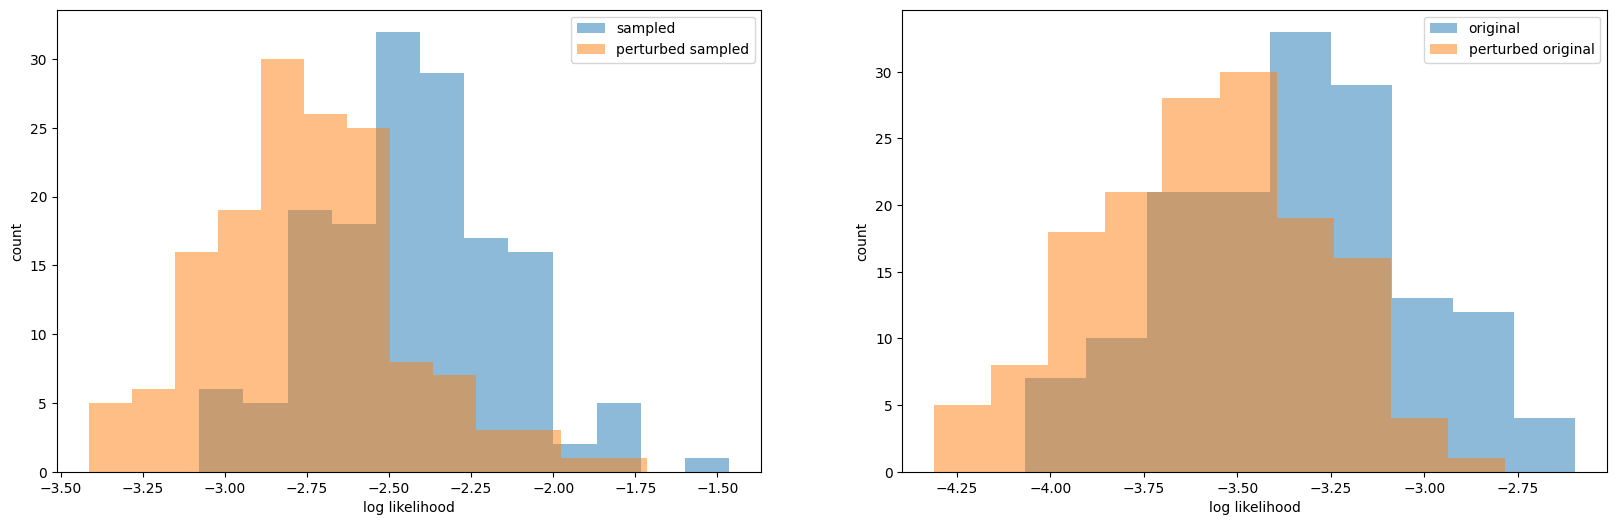

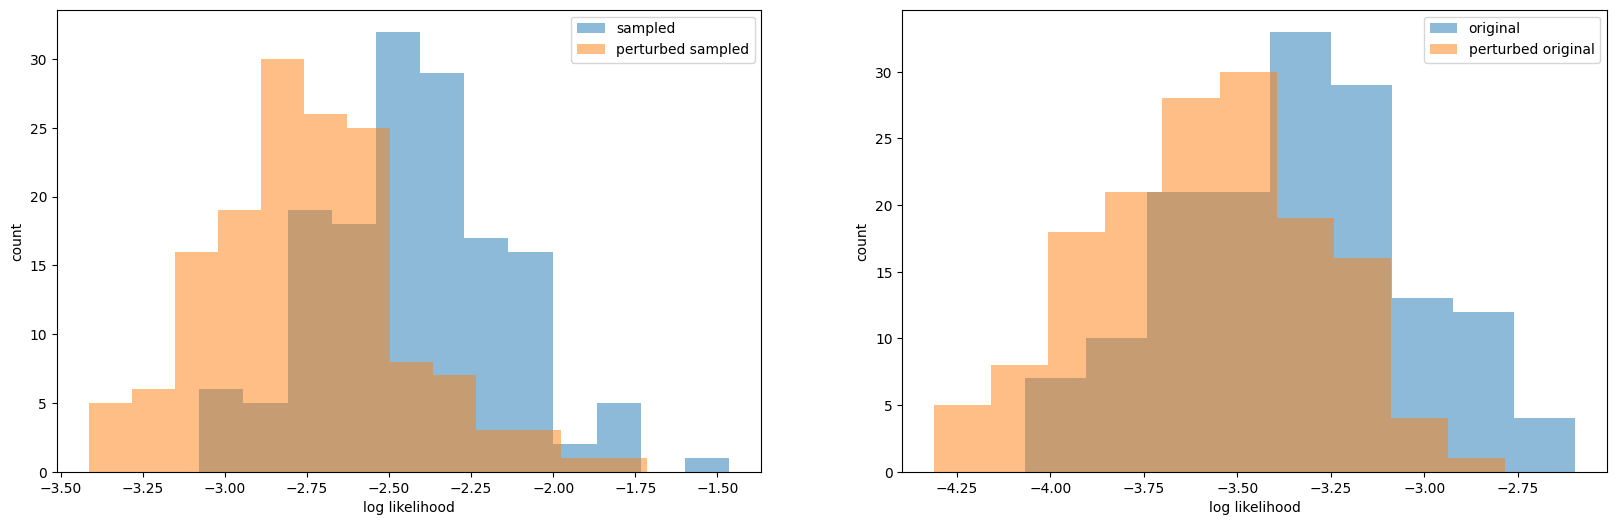

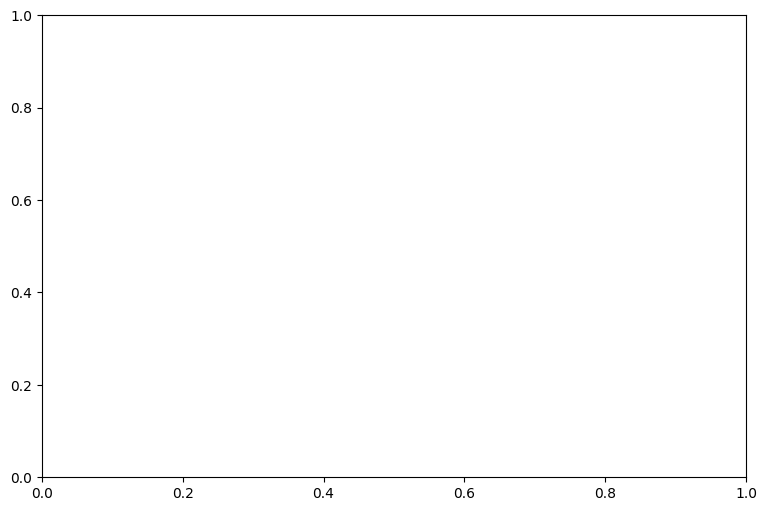

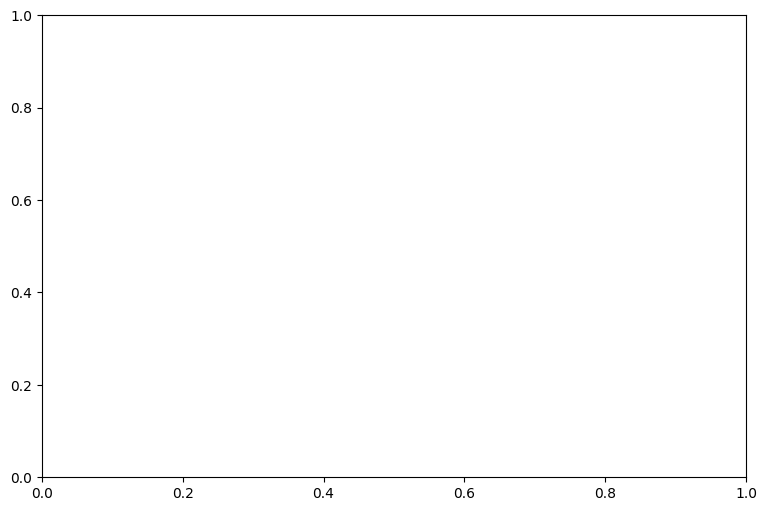

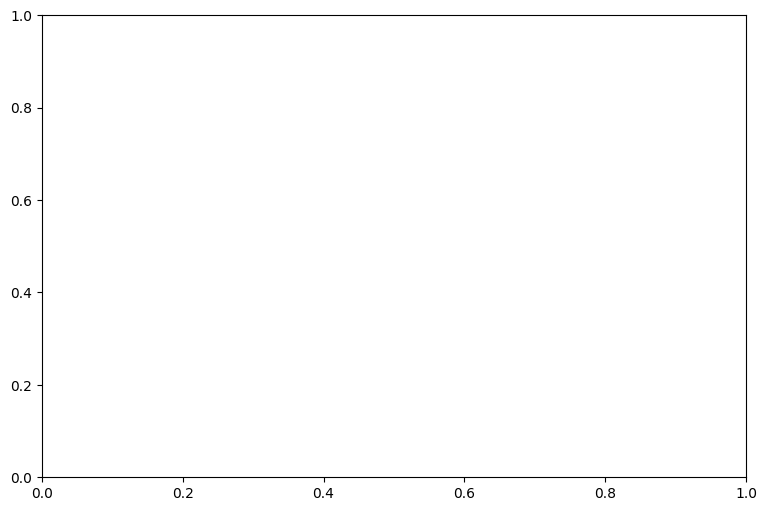

<Figure size 2000x600 with 0 Axes>

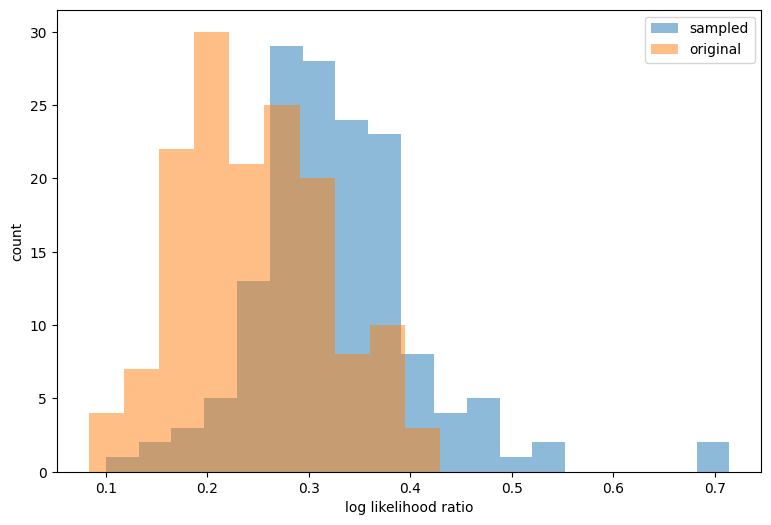

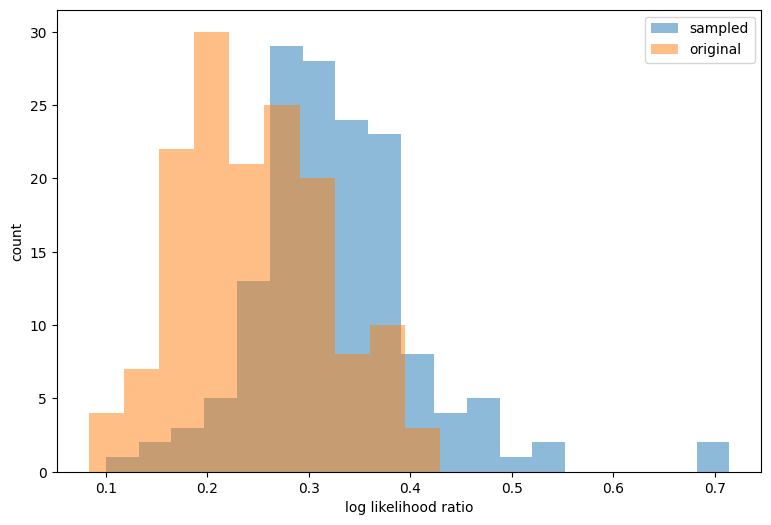

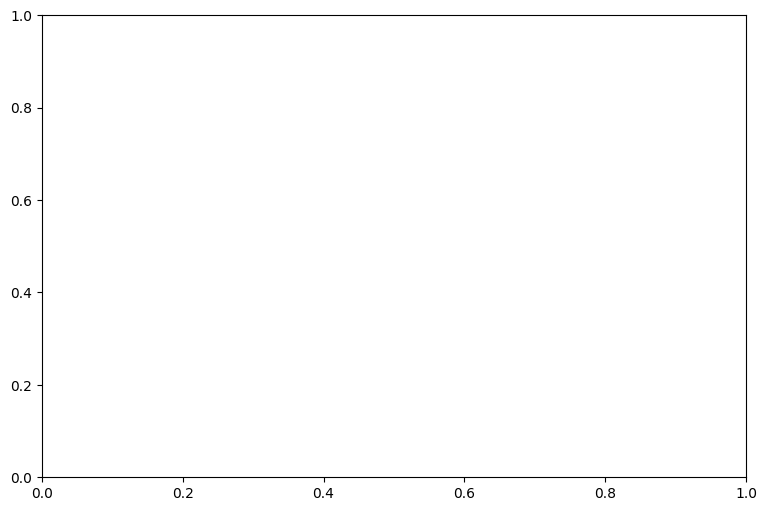

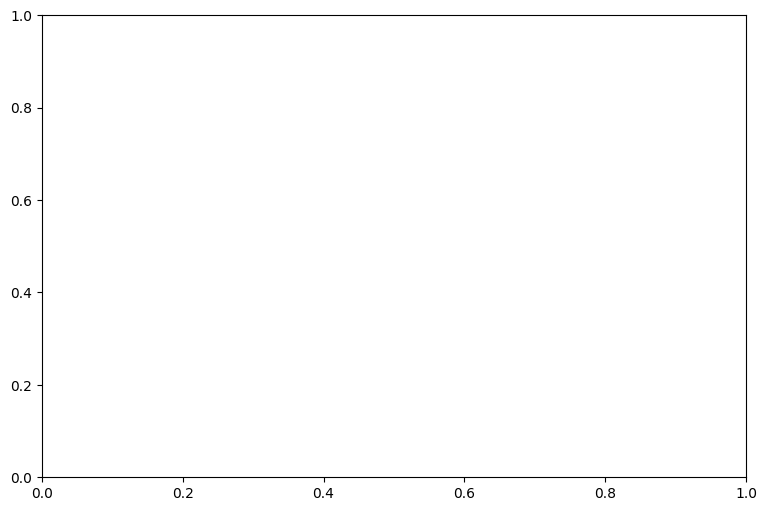

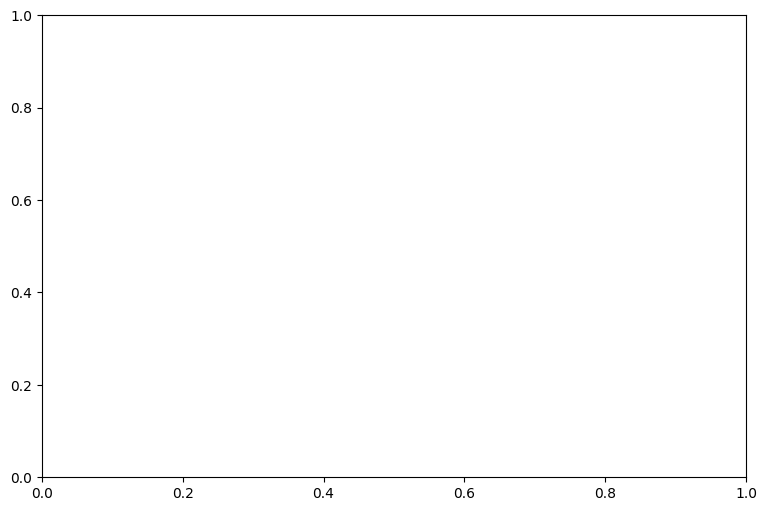

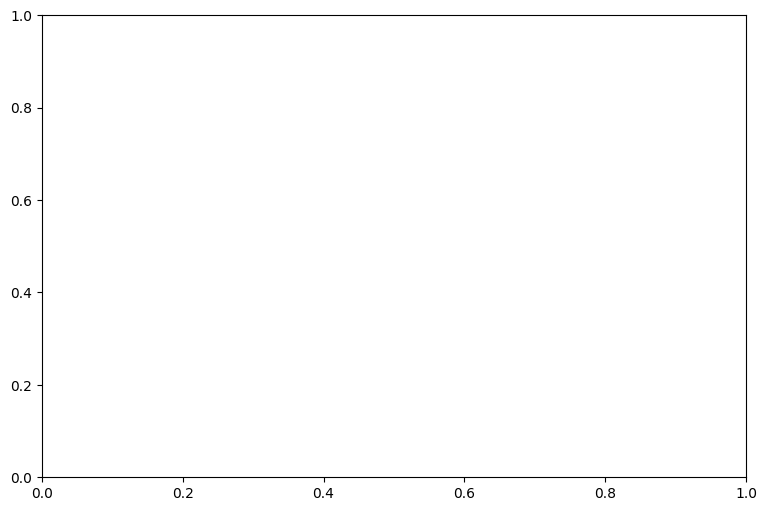

In [ ]:
save_roc_curves(outputs)
save_ll_histograms(outputs)
save_llr_histograms(outputs)

    # move results folder from tmp_results/ to results/, making sure necessary directories exist
new_folder = SAVE_FOLDER.replace("tmp_results", "results")
if not os.path.exists(os.path.dirname(new_folder)):
        os.makedirs(os.path.dirname(new_folder))
os.rename(SAVE_FOLDER, new_folder)

print(f"Used an *estimated* {API_TOKEN_COUNTER} API tokens (may be inaccurate)")

In [ ]:
!zip -r /content/results.zip /content/results
from google.colab import files
files.download("/content/results.zip")

  adding: content/results/ (stored 0%)
  adding: content/results/scale/ (stored 0%)
  adding: content/results/scale/gpt2-t5-small-top_p/ (stored 0%)
  adding: content/results/scale/gpt2-t5-small-top_p/2023-11-24-09-04-42-843141-fp32-0.3-1-multi_news-150/ (stored 0%)
  adding: content/results/scale/gpt2-t5-small-top_p/2023-11-24-09-04-42-843141-fp32-0.3-1-multi_news-150/roberta-base-openai-detector_results.json (deflated 67%)
  adding: content/results/scale/gpt2-t5-small-top_p/2023-11-24-09-04-42-843141-fp32-0.3-1-multi_news-150/raw_data.json (deflated 60%)
  adding: content/results/scale/gpt2-t5-small-top_p/2023-11-24-09-04-42-843141-fp32-0.3-1-multi_news-150/perturbation_10_d_results.json (deflated 87%)
  adding: content/results/scale/gpt2-t5-small-top_p/2023-11-24-09-04-42-843141-fp32-0.3-1-multi_news-150/llr_histograms_perturbation_10_z.png (deflated 35%)
  adding: content/results/scale/gpt2-t5-small-top_p/2023-11-24-09-04-42-843141-fp32-0.3-1-multi_news-150/llr_histograms_perturbat

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>